# 1. Initialize Spark and the SparkSession

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import sparknlp

sparknlp.start()
#conf = SparkConf().setAppName('Spark Lab1')
#sc = SparkContext(conf=conf)

spark = SparkSession \
    .builder \
    .appName("Spark Lab1") \
    .config("spark.executor.memory", "15g") \
    .config("spark.driver.memory", "15g")\
    .config("spark.driver.maxResultSize","5g")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.0")\
    .getOrCreate()
spark



# 2. Import data and plot initial data information

In [3]:
# For whole data set
#dataDF = spark.read.options(sep='\t',header=True).csv('amazon_reviews_us_Wireless_v1_00.tsv')

# For the small file for hand in
dataDF = spark.read.options(sep=",",header=True).csv("amazon_data.csv")

print("Total Dataset Length: {}".format(dataDF.count()))
dataDF.createOrReplaceTempView("reviewData")
reviewData = dataDF
print("Active Dataset Length: {}".format(reviewData.count()))
reviewData.show()
#https://www.amazon.com/gp/vine/help

Total Dataset Length: 9002021
Active Dataset Length: 9002021
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   16414143|R3W4P9UBGNGH1U|B00YL0EKWE|     852431543|LG G4 Case Hard T...|        Wireless|          2|            1|          3|   N|                Y|Looks good, funct...|2 issues  -  Once...| 2015-08-31|
|         US|   50800750|R15V54KBMTQWAY|B00XK95RPQ|     516

# Plot Vine rating distribution

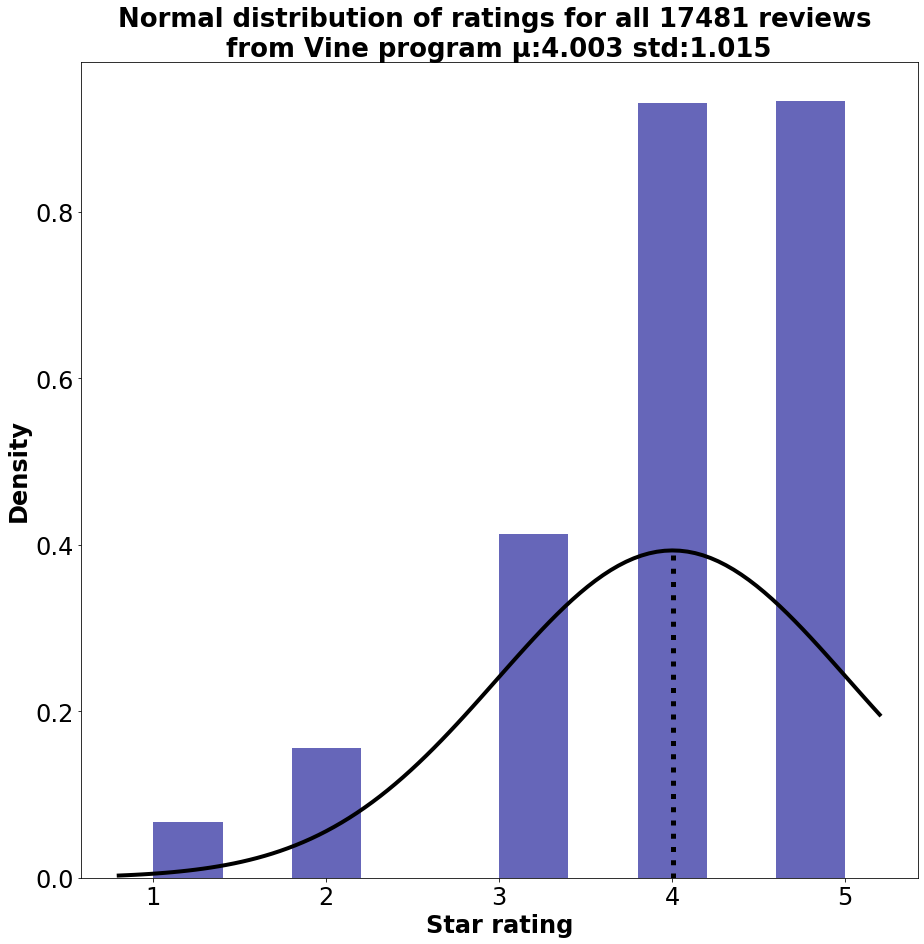

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
totalRatings = np.array(reviewData.filter(reviewData.vine =="Y").select("star_rating").collect(),dtype=float)
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 24,"font.weight":"light"})
#totalRatings = np.array(reviewData.select("star_rating").collect())

ratingMu,ratingStd = norm.fit(totalRatings)

plt.hist(totalRatings,density=True,alpha=0.6, facecolor="darkblue")
ratingXmin, ratingXmax = plt.xlim()
ratingX = np.linspace(ratingXmin, ratingXmax, 100)
ratingP = norm.pdf(ratingX,ratingMu,ratingStd)
plt.xlabel("Star rating",fontsize=24,fontweight="heavy")
plt.ylabel("Density",fontsize=24,fontweight="heavy")
plt.plot(ratingX,ratingP,'k',linewidth=4)
plt.title("Normal distribution of ratings for all {} reviews \nfrom Vine program \u03BC:{} std:{}".format(totalRatings.shape[0],np.round(ratingMu,3),np.round(ratingStd,3)),fontsize=26,fontweight="heavy")
plt.vlines(ratingMu,ymin=0,ymax=np.max(ratingP),linestyles="dotted",linewidth=5)

plt.savefig("datasetRatingDist_vine.png")
plt.show()

# Count percentage of reviews in vine-program

In [4]:
amountOfReviewsTotal = dataDF.count()
amountOfVineReviews = dataDF.filter(dataDF.vine =="Y").count()
print("Amount of reviews in total: {}\nAmount of reviews from Vine program: {}\nVine program percentage: {}%".format(amountOfReviewsTotal,amountOfVineReviews,round((amountOfVineReviews/amountOfReviewsTotal)*100,4) ))

Amount of reviews in total: 9002021
Amount of reviews from Vine program: 17481
Vine program percentage: 0.1942%


In [5]:
reviewData.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



# Filter out all products except the 100 with the most reviews

In [6]:
top100products_reviewAmount= reviewData.select("product_id","review_id").groupBy("product_id").count().orderBy("count",ascending=False).limit(100)

top100ProductIDs = top100products_reviewAmount.select("product_id").rdd.map(lambda product: product.product_id).collect()

reviewData = reviewData.filter(reviewData.product_id.isin(top100ProductIDs))
top100products_reviewAmount.show()
print("Total amount of reviews: {}".format(reviewData.count()))

+----------+-----+
|product_id|count|
+----------+-----+
|B009A5204K|10270|
|B0073FE1F0| 9946|
|B007FHX9OK| 9468|
|B0042FV2SI| 8866|
|B009SYZ8OC| 8801|
|B009USAJCC| 8055|
|B005X1Y7I2| 8023|
|B002BBJMO6| 7864|
|B0093QER4C| 7112|
|B003PPGOC0| 7087|
|B005IMB5NG| 6950|
|B00622AG6S| 6921|
|B002OL2MU4| 6913|
|B00B3OA7R8| 6521|
|B00EL94RQE| 6297|
|B00GTGETFG| 6270|
|B0097BEFYA| 6045|
|B000S5Q9CA| 6019|
|B0015RB39O| 5831|
|B0088LYCZC| 5588|
+----------+-----+
only showing top 20 rows

Total amount of reviews: 450164


# Construct DF with id to title for extraction later

In [7]:
productIdToTitle = reviewData.select("product_id","product_title").distinct()

# 3. Drop uninteresting columns and rows with missing data or error in input. Also filter out rows without verified purchase and drop the verified purchase column. Also convert vine column to integers instead of Y/N

In [8]:
# Drop the marketplace column and product_category column since they are the same for every product

columnsToDrop = ["marketplace","product_category","product_title",\
                 "product_parent","customer_id","review_date","vine",\
                "helpful_votes","total_votes","review_headline"]

reviewData = reviewData.drop().dropna().dropDuplicates()
reviewData = reviewData.filter(reviewData.verified_purchase == "Y")
reviewData = reviewData.drop("verified_purchase")
reviewData = reviewData.withColumn("star_rating", reviewData.star_rating.cast("int"))



# Plot the rating distribution of the data set

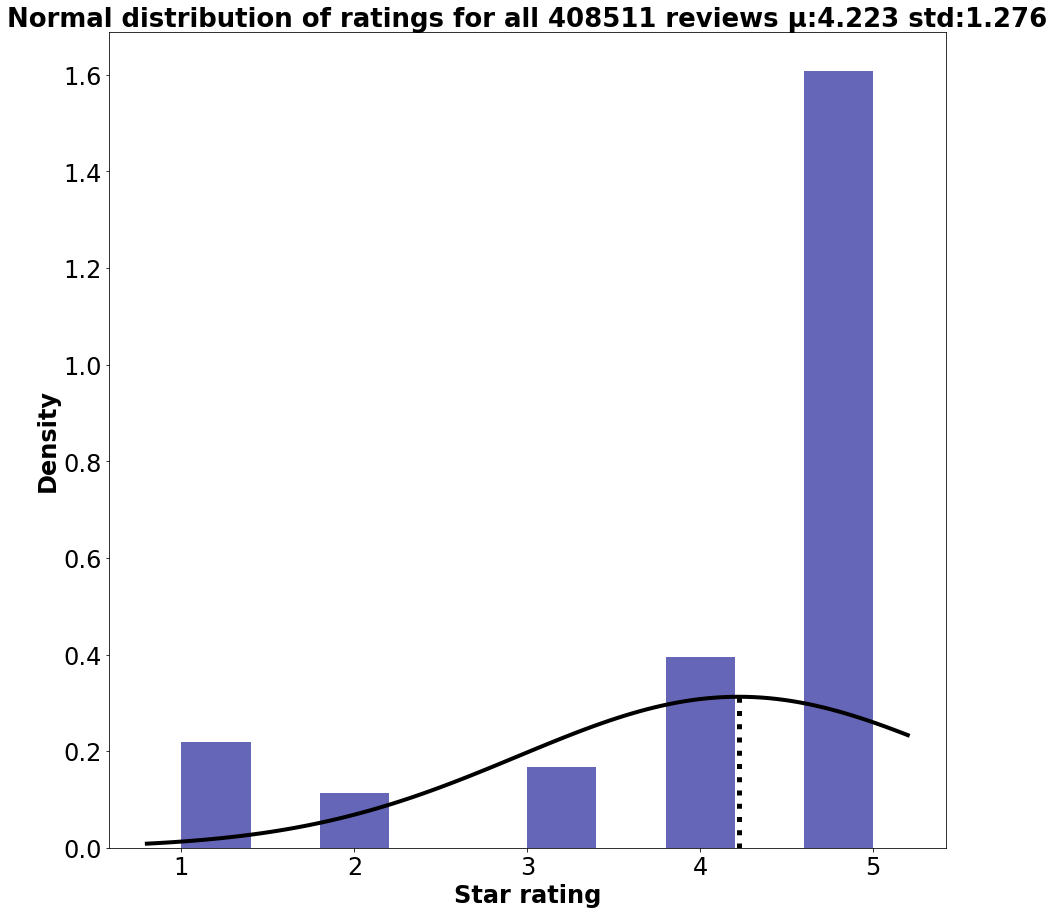

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 24,"font.weight":"light"})
totalRatings = np.array(reviewData.select("star_rating").collect())

ratingMu,ratingStd = norm.fit(totalRatings)

plt.hist(totalRatings,density=True,alpha=0.6, facecolor="darkblue")
ratingXmin, ratingXmax = plt.xlim()
ratingX = np.linspace(ratingXmin, ratingXmax, 100)
ratingP = norm.pdf(ratingX,ratingMu,ratingStd)
plt.xlabel("Star rating",fontsize=24,fontweight="heavy")
plt.ylabel("Density",fontsize=24,fontweight="heavy")
plt.plot(ratingX,ratingP,'k',linewidth=4)
plt.title("Normal distribution of ratings for all 408511 reviews \u03BC:{} std:{}".format(np.round(ratingMu,3),np.round(ratingStd,3)),fontsize=26,fontweight="heavy")
plt.vlines(ratingMu,ymin=0,ymax=np.max(ratingP),linestyles="dotted",linewidth=5)

plt.savefig("datasetRatingDist.png")
plt.show()

# 4. Perform various cleaning

In [12]:
import pyspark.sql.functions as sqlFunc


# make review_body lower case
reviewData_temp = reviewData.withColumn("review_body",sqlFunc.lower(sqlFunc.col("review_body")))

# Clean data using various regex replacements
# 1) Removing non-letters
reviewData_temp = reviewData_temp.withColumn("review_body",sqlFunc.regexp_replace("review_body","[^a-zA-Z\\s]",""))
# 2) Removing repetitive spaces
reviewData_temp = reviewData_temp.withColumn("review_body",sqlFunc.regexp_replace("review_body","\s{2,}"," "))
# 3) Removing spaces at start of word
reviewData_cleaned = reviewData_temp.withColumn("review_body",sqlFunc.regexp_replace("review_body","^(\s)",""))
reviewData_cleaned.persist()
reviewData_cleaned.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+--------------------+--------------------+-----------+
|         US|   39260328| R76XJ4GUZR4W7|B0093QER4C|     995428744|iPhone 5 / 5S / 5...|        Wireless|          5|            0|          0|   N|          Five Stars|great seller fast...| 2015-08-31|
|         US|   36691206|R2CRYYFAEFMDGK|B009USAJCC|     754737455|Anker Astro E3 Ul...|        Wireless|          4|            0|          0|   N|I love this produ...|i love this produ...| 20

# Construct pipeline for cleaning the review body performing tokenization, lemmatization, removing stopwords and performing POS-tagging

In [13]:
from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import SentenceDetector,Tokenizer, LemmatizerModel, StopWordsCleaner,PerceptronModel

from nltk.corpus import stopwords

from pyspark.ml import Pipeline

# loading stopwords from nltk
stopWords = stopwords.words('english')
stopWords.remove("no")


documentAssembler = DocumentAssembler()\
                    .setInputCol("review_body")\
                    .setOutputCol("review_raw")

sentenceDetector = SentenceDetector()\
                    .setInputCols(["review_raw"])\
                    .setOutputCol("review_sentences")


tokenizer = Tokenizer()\
            .setInputCols(["review_sentences"])\
            .setOutputCol("review_tokenized")

lemmatizer = LemmatizerModel.pretrained()\
            .setInputCols(["review_tokenized"])\
            .setOutputCol("review_lemmatized")

stopWords_cleaner = StopWordsCleaner()\
                    .setInputCols(["review_lemmatized"])\
                    .setOutputCol("review_cleaned")\
                    .setStopWords(stopWords)


pos_tagger = PerceptronModel.pretrained()\
            .setInputCols(["review_raw","review_cleaned"])\
            .setOutputCol("review_tagged")

finisher = Finisher()\
            .setInputCols(["review_cleaned","review_tagged"])\
    

review_pipeline = Pipeline()\
                .setStages([
                            documentAssembler,
                            sentenceDetector,
                            tokenizer,
                            lemmatizer,
                            stopWords_cleaner,
                            pos_tagger,
                            finisher
                            ])
            

lemma_antbnc download started this may take some time.
Approximate size to download 907,6 KB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 4,3 MB
[OK!]


In [14]:
pipeline_model = review_pipeline.fit(reviewData_cleaned)
reviewData_preprocessed = pipeline_model.transform(reviewData_cleaned)#.select("finished_review_cleaned").show()

reviewData_preprocessed = reviewData_preprocessed.withColumn("review_tagged",sqlFunc.arrays_zip("finished_review_cleaned","finished_review_tagged"))

reviewData_preprocessed = reviewData_preprocessed.withColumn("review_body_lem",sqlFunc.concat_ws(" ","finished_review_cleaned"))

reviewData_preprocessed = reviewData_preprocessed.drop("finished_review_cleaned","finished_review_tagged")



reviewData_preprocessed = reviewData_preprocessed.groupBy("product_id").agg(sqlFunc.collect_list("star_rating").alias("star_ratings"),\
                                                 sqlFunc.collect_list("review_body").alias("reviews_body"),\
                                                 sqlFunc.collect_list("review_body_lem").alias("reviews_body_lem"),\
                                                 sqlFunc.collect_list("review_tagged").alias("reviews_tagged"))
reviewData_preprocessed.persist()
reviewData_preprocessed.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|        star_ratings|        reviews_body|    reviews_body_lem|      reviews_tagged|
+----------+--------------------+--------------------+--------------------+--------------------+
|B008GVL9YQ|[5, 2, 5, 4, 1, 4...|[works perfectly ...|[work perfectly h...|[[[work, NN], [pe...|
|B000LRMS66|[5, 5, 5, 5, 5, 5...|[my previous garm...|[previous garmin ...|[[[previous, JJ],...|
|B0088U6OZY|[5, 4, 4, 5, 5, 5...|[the best car cha...|[good car charger...|[[[good, JJ], [ca...|
|B00D82O68Y|[5, 5, 3, 5, 5, 5...|[i love this char...|[love charger wor...|[[[love, NN], [ch...|
|B00MXDZFFM|[5, 5, 4, 3, 1, 3...|[i thought it was...|[think water proo...|[[[think, VBP], [...|
|B005LKB0IU|[1, 5, 5, 5, 5, 1...|[these things fit...|[thing fit maybe ...|[[[thing, NN], [f...|
|B008MOHLVC|[2, 5, 5, 3, 5, 5...|[flimsy and feels...|[flimsy feel chea...|[[[flimsy, JJ], [...|
|B00896EZB2|[5, 5, 3, 5, 4, 5.

# Calculate Sentiment for reviews

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import json

sentiment = SentimentIntensityAnalyzer()
def sentimentUDF(revs):
    return [float(sentiment.polarity_scores(rev)["compound"]) for rev in revs]

spark.udf.register("sentiment",sentimentUDF)

reviewData_sent = reviewData_preprocessed.selectExpr("*","sentiment(reviews_body)").withColumnRenamed("sentiment(reviews_body)","sentiments")
reviewData_sent = reviewData_sent.withColumn("sentiments", sqlFunc.array_remove(sqlFunc.split("sentiments",",|\[|]"),"").cast("array<float>") )
reviewData_sent.show()
reviewData_sent.persist()

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|product_id|        star_ratings|        reviews_body|    reviews_body_lem|      reviews_tagged|          sentiments|
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|B008GVL9YQ|[5, 2, 5, 4, 1, 4...|[works perfectly ...|[work perfectly h...|[[[work, NN], [pe...|[0.7425, 0.1901, ...|
|B000LRMS66|[5, 5, 5, 5, 5, 5...|[my previous garm...|[previous garmin ...|[[[previous, JJ],...|[-0.7096, 0.0, 0....|
|B0088U6OZY|[5, 4, 4, 5, 5, 5...|[the best car cha...|[good car charger...|[[[good, JJ], [ca...|[0.6369, -0.2263,...|
|B00D82O68Y|[5, 5, 3, 5, 5, 5...|[i love this char...|[love charger wor...|[[[love, NN], [ch...|[0.743, 0.296, 0....|
|B00MXDZFFM|[5, 5, 4, 3, 1, 3...|[i thought it was...|[think water proo...|[[[think, VBP], [...|[0.1901, 0.7759, ...|
|B005LKB0IU|[1, 5, 5, 5, 5, 1...|[these things fit...|[t

DataFrame[product_id: string, star_ratings: array<int>, reviews_body: array<string>, reviews_body_lem: array<string>, reviews_tagged: array<array<struct<finished_review_cleaned:string,finished_review_tagged:string>>>, sentiments: array<float>]

# Plot total distribution of review sentiments

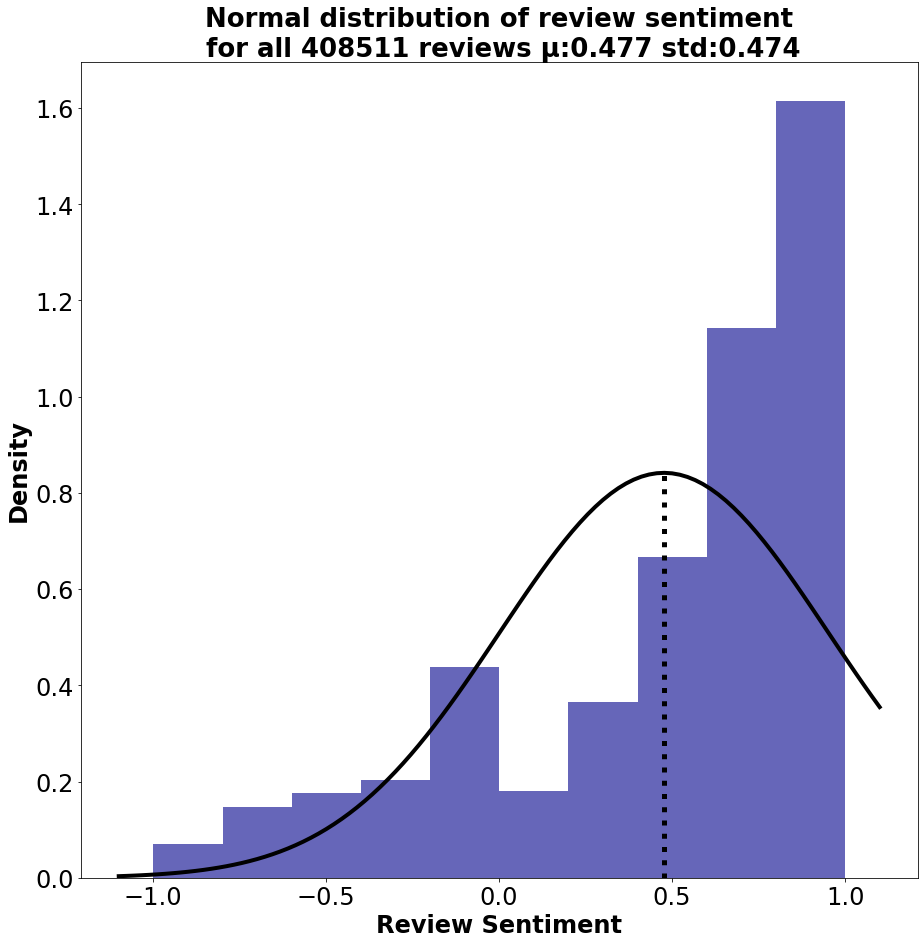

In [17]:

plt.figure(figsize=(15,15))

plt.rcParams.update({'font.size': 24,"font.weight":"light"})
totalSentiments = np.array(reviewData_sent.select(sqlFunc.explode("sentiments")).collect())
totalSentiments = totalSentiments.flatten()

sentimentMu,sentimentStd = norm.fit(totalSentiments)

plt.hist(totalSentiments,density=True,alpha=0.6, facecolor="darkblue")
sentimentXmin, sentimentXmax = plt.xlim()
sentimentX = np.linspace(sentimentXmin, sentimentXmax, 100)
sentimentP = norm.pdf(sentimentX,sentimentMu,sentimentStd)
plt.xlabel("Review Sentiment",fontsize=24,fontweight="heavy")
plt.ylabel("Density",fontsize=24,fontweight="heavy")
plt.plot(sentimentX,sentimentP,'k',linewidth=4)
plt.title("Normal distribution of review sentiment\n for all 408511 reviews \u03BC:{} std:{}".format(np.round(sentimentMu,3),np.round(sentimentStd,3)),fontsize=26,fontweight="heavy")
plt.vlines(sentimentMu,ymin=0,ymax=np.max(sentimentP),linestyles="dotted",linewidth=5)

plt.savefig("datasetSentimentDist.png")
plt.show()

# Filter out words that are not Verbs, Adverbs or Nouns

In [ ]:


# Load in columns for pos-tag filtering
review_tags = reviewData_preprocessed.select("product_id",sqlFunc.explode("reviews_tagged").alias("review_tagged"))

review_tags = review_tags.selectExpr("product_id","filter(review_tagged, x -> ((x.finished_review_tagged rlike '(VB\w+|VB)|(RB\w|\bRB)|(NN\w+|NN)') or (x.finished_review_cleaned == 'no'))) review_tagged_filtered")

review_tags_filtered = review_tags.selectExpr("product_id","transform(review_tagged_filtered, x -> x.finished_review_cleaned) review_words")





# Construct N-Grams for reviews

In [ ]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol= "review_words", outputCol="review_ngrams")

review_ngramDF = ngram.transform(review_tags_filtered.select("product_id","review_words"))

#review_ngramDF = review_ngramDF.withColumn("review_ngrams", sqlFunc.array_distinct("review_ngrams"))
review_ngramDF = review_ngramDF.withColumn("review_ngrams_unique", sqlFunc.array_distinct("review_ngrams"))

review_ngramDF = review_ngramDF.groupBy("product_id").agg(sqlFunc.collect_list("review_ngrams").alias("review_ngrams"),sqlFunc.collect_list("review_ngrams_unique").alias("review_ngrams_unique"))

review_ngramDF = review_ngramDF.withColumn("review_amount",sqlFunc.size("review_ngrams"))
review_ngramDF.show()

# Join Ngram-DF with Main DF

In [ ]:
review_Data = reviewData_sent.join(review_ngramDF,on="product_id")
review_Data = review_Data.drop("reviews_tagged")
review_Data.persist()
review_Data.show()

# Calculate TF-IDF of word pairs for each product

In [ ]:
import numpy as np
from pyspark.sql.types import ArrayType
from pyspark.sql.functions import expr

countedTF = review_ngramDF.select("product_id","review_amount", sqlFunc.explode(sqlFunc.flatten("review_ngrams")).alias("review_ngrams")).groupBy("product_id","review_amount","review_ngrams").count().orderBy("count",ascending=False)
                       
countedDF = review_ngramDF.select("product_id","review_amount", sqlFunc.explode(sqlFunc.flatten("review_ngrams_unique")).alias("review_ngrams")).groupBy("product_id","review_amount","review_ngrams").count().orderBy("count",ascending=False)

countedTF = countedTF.withColumnRenamed("count","TF")
countedDF = countedDF.withColumnRenamed("count","DF")

counted = countedTF.join(countedDF,on=["product_id","review_amount","review_ngrams"])
counted = counted.withColumn("IDF", sqlFunc.log(10.0, (counted.review_amount + 1) / (counted.DF +1)))
counted = counted.withColumn("TFIDF", counted.TF * counted.IDF)
counted = counted.orderBy("TFIDF",ascending=False)


ngram_freq = counted.groupBy("product_id").agg(sqlFunc.collect_list("review_ngrams").alias("review_ngrams"),sqlFunc.collect_list("TFIDF").alias("TFIDF"))


def normalizeArrayValues(values):
    maxVal = np.max(values)
    minVal = np.min(values)
    return [(value - minVal)/(maxVal - minVal) for value in values]

normalizeArrayUDF = udf(normalizeArrayValues,ArrayType(DoubleType()))



ngram_freq = ngram_freq.select("product_id",sqlFunc.slice("review_ngrams",1,15).alias("review_ngrams"),sqlFunc.slice("TFIDF",1,15).alias("TFIDF"),\
                               sqlFunc.array_repeat(sqlFunc.array_min("TFIDF"),15).alias("TFIDF_min"),sqlFunc.array_repeat(sqlFunc.array_max("TFIDF"),15).alias("TFIDF_max"))

# Normalize the TFIDF score
ngram_freq = ngram_freq.withColumn("TFIDF_norm",expr("transform(arrays_zip(TFIDF,TFIDF_min,TFIDF_max), x -> (x.TFIDF - x.TFIDF_min)/(x.TFIDF_max - x.TFIDF_min))  "))

ngram_freq = ngram_freq.select("product_id", sqlFunc.arrays_zip("review_ngrams","TFIDF_norm").alias("ngrams_freq"))


ngram_freq.show()

# Join N-gram count with idsWithAllReviews

In [ ]:
reviewsWithNgrams = review_Data.join(ngram_freq,on="product_id")
reviewsWithNgrams = reviewsWithNgrams.drop("review_ngrams","review_ngrams_unique")
reviewsWithNgrams.persist()
reviewsWithNgrams = reviewsWithNgrams.orderBy(reviewsWithNgrams.review_amount,ascending=False)
review_Data.unpersist()

# Calculate the mean rating and sentiment of the reviews of which each N-gram is present in

In [ ]:
import numpy as np


def calc_meanAndStd_sent_rating(reviews,ngrams):
    
    ngram_vals= {}
    for ngram in ngrams:
        ngram_vals[ngram] = [[],[]]
        temp_sents = []
        temp_ratings = []
        for index, review in enumerate(reviews):
            if review[0] != None:
                if ngram[0] in review[0]:
                    temp_sents.append(review[1])
                    temp_ratings.append(review[2])
  

        ngram_vals[ngram][0].append(float(round(np.mean(temp_sents),4)))
        ngram_vals[ngram][0].append(float(round(np.std(temp_sents),4)))
        
        ngram_vals[ngram][1].append(float(round(np.mean(temp_ratings),4)))
        ngram_vals[ngram][1].append(float(round(np.std(temp_ratings),4)))
                

    return ngram_vals
    
reviews_ngram_zipped_sent_rating = reviewsWithNgrams.select("product_id","ngrams_freq", sqlFunc.arrays_zip("reviews_body_lem","sentiments","star_ratings").alias("zipped_review"),"review_amount")

print("Calculating mean sentiments and ratings for ngrams")
reviewsWithNgramSent = reviews_ngram_zipped_sent_rating.rdd.map(lambda x: (x.product_id,calc_meanAndStd_sent_rating(x.zipped_review,x.ngrams_freq)))

print("Data extraction 1")
reviewsWithNgramSent = reviewsWithNgramSent.map(lambda x: (x[0], list(x[1].keys()),list(x[1].values())))

print("Data extraction 2")
reviewsWithNgramSent = reviewsWithNgramSent.map(lambda x: (x[0],x[1], np.array(x[2])[:,0].tolist() , np.array(x[2])[:,1].tolist()))

print("Data extraction 4")
reviewsWithNgramSent = reviewsWithNgramSent.map(lambda x: (x[0],x[1], np.array(x[2])[:,0].tolist() ,np.array(x[2])[:,1].tolist(), np.array(x[3])[:,0].tolist(),np.array(x[3])[:,1].tolist()))

schema = ["product_id", "ngrams_freq","ngramSent_mean","ngramSent_std","ngramRating_mean","ngramRating_std"]

print("Converting to DF")
reviewsWithNgramSent = reviewsWithNgramSent.toDF(schema)
reviewsWithNgramSent.persist()




# Function for plotting the data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from scipy.stats import norm
from matplotlib.cm import ScalarMappable
from textwrap import wrap

def plot_product_ngrams(product_id):
    product_name = productIdToTitle.filter(productIdToTitle.product_id == product_id).select("product_title").collect()[0].product_title
    
    fig = plt.figure(figsize=(20,20))
    
    product_title = "\n".join(wrap(product_name, 80))
    
    plt.suptitle(product_title,fontsize=18,fontweight="heavy")

    plt.rcParams.update({'font.size': 16,"font.weight":"light"})
    fig.patch.set_facecolor('#E0E0E0')
    fig.patch.set_alpha(0.7)
    
    
    selectedProductNgrams = reviewsWithNgramSent.filter(reviewsWithNgramSent.product_id == product_id)
    
    # Get data for product sentiment and rating-plot
    
    ratingsAndSentiments = reviewsWithNgrams.filter(reviewsWithNgrams.product_id == product_id).first()
    
    ratingMu,ratingStd = norm.fit(ratingsAndSentiments.star_ratings)
    

    ax1 = plt.subplot2grid((6,6),(0,0),colspan=2,rowspan=2)
    ratingMu,ratingStd = norm.fit(ratingsAndSentiments.star_ratings)
    ax1.hist(ratingsAndSentiments.star_ratings,density=True,alpha=0.6, facecolor="darkblue")
    ratingXmin, ratingXmax = ax1.get_xlim()
    ratingX = np.linspace(ratingXmin, ratingXmax, 100)
    ratingP = norm.pdf(ratingX,ratingMu,ratingStd)
    ax1.plot(ratingX,ratingP,'k',linewidth=4)
    ax1.vlines(ratingMu,ymin=0,ymax=np.max(ratingP),linestyles="dotted",linewidth=4)
    
    ax1.set_title("Rating Normal Distribution \u03BC:{} std:{}".format(np.round(ratingMu,3),np.round(ratingStd,3)),fontdict={"fontsize":18,"fontweight":"heavy"})
    ax1.set_xlabel("Rating",fontsize=18)
    ax1.set_ylabel("Density",fontsize=18)
    
    ax2 = plt.subplot2grid((6,6),(2,0),colspan=2,rowspan=2)
    sentimentMu,sentimentStd = norm.fit(ratingsAndSentiments.sentiments)
    ax2.hist(ratingsAndSentiments.sentiments,density=True,alpha=0.6, facecolor="darkblue")
    sentimentXmin, sentimentXmax = ax2.get_xlim()
    sentimentX = np.linspace(sentimentXmin, sentimentXmax, 100)
    sentimentP = norm.pdf(sentimentX,sentimentMu,sentimentStd)
    ax2.plot(sentimentX,sentimentP,'k',linewidth=4)
    
    ax2.vlines(sentimentMu,ymin=0,ymax=np.max(sentimentP),linestyles="dotted",linewidth=4)

    
    ax2.set_title("Sentiment Normal Distribution \u03BC:{} std:{}".format(np.round(sentimentMu,3),np.round(sentimentStd,3)),fontdict={"fontsize":16,"fontweight":"heavy"})
    ax2.set_xlabel("Sentiment",fontsize=18)
    ax2.set_ylabel("Density",fontsize=18)
    
    
    # Get data for ngram-count subplot
    ngrams_count = np.array(selectedProductNgrams.select("ngrams_freq").collect()[0][0])
    ngrams = ngrams_count[:,0]
    ngram_freq = ngrams_count[:,1].astype(np.float)
    ngram_sent = np.array(selectedProductNgrams.select("ngramSent_mean").collect()[0][0])
    ngram_rating = np.array(selectedProductNgrams.select("ngramRating_mean").collect()[0][0])
    ngram_sent_std = np.array(selectedProductNgrams.select("ngramSent_std").collect()[0][0])
    ngram_rating_std = np.array(selectedProductNgrams.select("ngramRating_std").collect()[0][0])
    
    
    
    ax3 = plt.subplot2grid((6,6),(0,3),colspan=3,rowspan=6)
    
    pointSize = 400 * (ngram_sent_std * ngram_rating_std) 
    #print(pointSize)
    #plt.scatter()
    ax3.scatter(ngram_sent,ngram_rating,s=pointSize,c=ngram_freq,edgecolors="black",alpha=0.8,cmap="Blues")

    #ax3.scatter(ngram_sent,ngram_rating,s=200,c=ngram_freq,edgecolors="black",alpha=0.8,cmap="Blues")

    ax3.set_xlabel("Mean review sentiment",fontsize=18)
    ax3.set_ylabel("Mean review rating",fontsize=18)
    ax3.set_title("N-gram mean sentiment and rating with frequency",fontdict={"fontsize":18,"fontweight":"heavy"})
    
    
    nrm = plt.Normalize(ngram_freq.min(), ngram_freq.max())
    sm =  ScalarMappable(norm=nrm, cmap="Blues")
    colorbar = plt.colorbar(sm,ax=ax3,orientation="horizontal")
    #colorbar.set_label("Percentage of reviews containing the N-gram")
    colorbar.set_label("N-gram TF-IDF score",fontsize=18)
    
    texts = []
    for i ,ngram in enumerate(ngrams):
        texts.append(ax3.text(ngram_sent[i],ngram_rating[i],ngram))
        
    adjust_text(texts, expand_text=(1.5,1.5),expand_points=(1.5,1.5), arrowprops=dict(arrowstyle="-", color='black'))
    
    plt.tight_layout(rect=(0,0,1,0.94))
    
    plt.savefig("test.png")
    plt.show()
    


# Show interactive plot

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display as disp

top100ProductIDRows = reviewsWithNgrams.select("product_id",sqlFunc.size("star_ratings").alias("rating_amount")).collect()
top100ProductIDs = []
for prod in top100ProductIDRows:
    #top50ProductIDs.append("ID:{} Review Amount:{}".format(prod.product_id,length)
    top100ProductIDs.append(prod.product_id)
    
interact(plot_product_ngrams, product_id = top100ProductIDs);
#positive
#B005LKB0IU


#negative reviews
#B00EL94RQE
#B0015RB39O
#B005WF9OHI

# Generate Latex tables for specific products

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from scipy.stats import norm
from matplotlib.cm import ScalarMappable
from textwrap import wrap
import pandas as pd

def plot_product_ngrams_tabular(product_id):
    product_name = productIdToTitle.filter(productIdToTitle.product_id == product_id).select("product_title").first().product_title
    
    
    product_title = "\n".join(wrap(product_name, 80))
    

    
    selectedProductNgrams = reviewsWithNgramSent.filter(reviewsWithNgramSent.product_id == product_id)
    
    # Get data for product sentiment and rating-plot
    
   
    # Get data for ngram-count subplot
    ngrams_count = np.array(selectedProductNgrams.select("ngrams_freq").collect()[0][0])
    ngrams = ngrams_count[:,0]
    ngram_freq = np.round(ngrams_count[:,1].astype(np.float),4)
    ngram_sent = np.round(np.array(selectedProductNgrams.select("ngramSent_mean").collect()[0][0]),4)
    ngram_rating = np.round(np.array(selectedProductNgrams.select("ngramRating_mean").collect()[0][0]),4)
    
    ngrams_array = np.array([ngrams,ngram_freq,ngram_sent,ngram_rating])

    
    pandasDF = pd.DataFrame(ngrams_array.T,columns=["ngrams","freq","sent","rating"])

    
    print(pandasDF.to_latex(index=False))


        
plot_product_ngrams_tabular("B005X1Y7I2")